### TRABAJO PRÁCTICO N° 4 MÉTODOS SUPERVISADOS: REGRESIÓN & CLASIFICACIÓN USANDO LA EHP

#### A. Enfoque de validación

###

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [4]:

class DivisionDatos:
    def __init__(self):
        self.variables_independientes = ['CH04', 'CH06', 'CAT_OCUP', 'PP02H', 'CH08']
        self.datos = None
        
    def cargar_datos(self, archivo="Base_Respondieron.xlsx"):
        self.datos = pd.read_excel(archivo)
        columnas_necesarias = ['ESTADO', 'ANO4'] + self.variables_independientes
        self.datos = self.datos.dropna(subset=columnas_necesarias)
        return self
    
    def preparar_variables(self, df):
        y = (df['ESTADO'] == 'Desocupado').astype(int)
        X = pd.get_dummies(df[self.variables_independientes], drop_first=True)
        X.insert(0, 'intercepto', 1)
        return X, y
    
    def dividir_por_año(self, año):
        df_año = self.datos[self.datos['ANO4'] == año].copy()
        if len(df_año) == 0:
            return None
        
        X, y = self.preparar_variables(df_año)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=444, stratify=y)
        
        return {
            'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'df_año': df_año, 'año': año
        }
    
    def guardar_datasets(self, resultado):
        año = resultado['año']
        
        train_df = resultado['X_train'].copy()
        train_df['y_desocupado'] = resultado['y_train'].values
        test_df = resultado['X_test'].copy()
        test_df['y_desocupado'] = resultado['y_test'].values
        
        train_df.astype(int).to_excel(f'train_data_{año}.xlsx', index=False)
        test_df.astype(int).to_excel(f'test_data_{año}.xlsx', index=False)
        
        df_año = resultado['df_año']
        X_original, y_original = self.preparar_variables(df_año)
        X_train_temp, X_test_temp, _, _ = train_test_split(X_original, y_original, test_size=0.7, random_state=444, stratify=y_original)
        
        df_año.loc[X_train_temp.index].to_excel(f'train_original_{año}.xlsx', index=False)
        df_año.loc[X_test_temp.index].to_excel(f'test_original_{año}.xlsx', index=False)
    
    def procesar_todos_los_años(self):
        for año in sorted(self.datos['ANO4'].unique()):
            resultado = self.dividir_por_año(año)
            if resultado:
                self.guardar_datasets(resultado)

def main():
    DivisionDatos().cargar_datos().procesar_todos_los_años()

if __name__ == "__main__":
    main() 

In [6]:
class AnalisisDiferenciasMedias:
    def __init__(self):
        self.años = [2004, 2024]
        
    def cargar_bases(self, año):
        train_df = pd.read_excel(f'train_data_{año}.xlsx')
        test_df = pd.read_excel(f'test_data_{año}.xlsx')
        return train_df, test_df
    
    def calcular_diferencias_medias(self, train_df, test_df, año):
        variables_x = [col for col in train_df.columns if col != 'y_desocupado']
        
        train_x = train_df[variables_x]
        test_x = test_df[variables_x]
        
        medias_train = train_x.mean()
        medias_test = test_x.mean()
        
        tabla_diferencias = pd.DataFrame({
            'Variable': variables_x,
            'Media_Train': medias_train.values,
            'Media_Test': medias_test.values,
            'Diferencia': (medias_train - medias_test).values,
            'Diferencia_Abs': abs(medias_train - medias_test).values,
            'Año': año
        })
        
        tabla_diferencias = tabla_diferencias.sort_values('Diferencia_Abs', ascending=False)
        return tabla_diferencias
    
    def analizar_todos_los_años(self):
        for año in self.años:
            train_df, test_df = self.cargar_bases(año)
            tabla = self.calcular_diferencias_medias(train_df, test_df, año)
            
            print(f"Año {año}:")
            print(f"  Variables: {len(tabla)}")
            print(f"  Mayor diferencia: {tabla['Diferencia_Abs'].max():.4f}")
            print(f"  Promedio diferencias: {tabla['Diferencia_Abs'].mean():.4f}")
            
            print("  Top 3 mayores diferencias:")
            for i, (_, row) in enumerate(tabla.head(3).iterrows()):
                print(f"    {i+1}. {row['Variable']}: {row['Diferencia']:.4f}")
            print()

analizador = AnalisisDiferenciasMedias()
analizador.analizar_todos_los_años()

Año 2004:
  Variables: 102
  Mayor diferencia: 0.0138
  Promedio diferencias: 0.0019
  Top 3 mayores diferencias:
    1. CH04_Varón: 0.0138
    2. CH08_No paga ni le descuentan: 0.0115
    3. CH08_Obra social (incluye PAMI): -0.0094

Año 2024:
  Variables: 106
  Mayor diferencia: 0.0078
  Promedio diferencias: 0.0018
  Top 3 mayores diferencias:
    1. CH04_Varón: 0.0078
    2. CH08_Obra social (incluye PAMI): 0.0063
    3. CH06_21: -0.0061



## C. Métodos de Clasificación y Performance - Punto 5.

Año: 2004
Modelo {modelo}
Matriz de Confusión:
[[8042    4]
 [ 561  164]]
AUC: 0.8837
Accuracy: 0.9356
Modelo {modelo}
Matriz de Confusión:
[[7897  149]
 [ 645   80]]
AUC: 0.7255
Accuracy: 0.9095


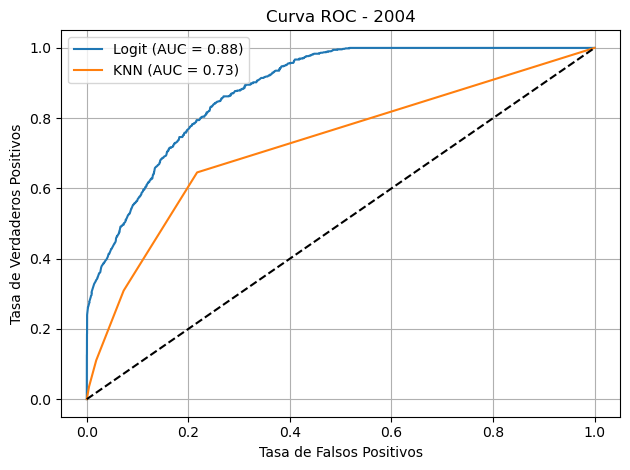

Año: 2024
Modelo {modelo}
Matriz de Confusión:
[[8546    2]
 [ 292   25]]
AUC: 0.8800
Accuracy: 0.9668
Modelo {modelo}
Matriz de Confusión:
[[8510   38]
 [ 304   13]]
AUC: 0.6849
Accuracy: 0.9614


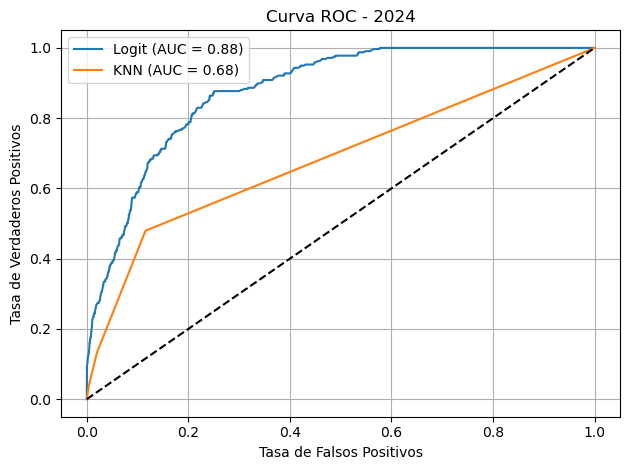

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

años = [2004, 2024]

for año in años:
    print(f"Año: {año}")
    
    train = pd.read_excel(f"train_data_{año}.xlsx")
    test = pd.read_excel(f"test_data_{año}.xlsx")

    X_train = train.drop(columns=['y_desocupado'])
    y_train = train['y_desocupado']

    X_test = test.drop(columns=['y_desocupado'])
    y_test = test['y_desocupado']

    # Modelo Logit
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X_train, y_train)
    prob_logit = logit.predict_proba(X_test)[:, 1]
    pred_logit = (prob_logit > 0.5).astype(int)

    # Modelo KNN (k=5)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    prob_knn = knn.predict_proba(X_test)[:, 1]
    pred_knn = (prob_knn > 0.5).astype(int)

    # Métricas
    for modelo, pred, probas in [('Logit', pred_logit, prob_logit), ('KNN', pred_knn, prob_knn)]:
        print(f"Modelo {modelo}")
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, pred))
        print(f"AUC: {roc_auc_score(y_test, probas):.4f}")
        print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")
        fpr, tpr, _ = roc_curve(y_test, probas)
        plt.plot(fpr, tpr, label=f"{modelo} (AUC = {roc_auc_score(y_test, probas):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"Curva ROC - {año}")
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

#plt.plot([0, 1], [0, 1], 'k--')
#plt.title(f"Curva ROC - {año}")
#plt.xlabel("Tasa de Falsos Positivos")
#plt.ylabel("Tasa de Verdaderos Positivos")
#plt.legend()
#plt.grid()
#plt.tight_layout()
#plt.show()

# (Si no incluimos la ultima linea dentro del conjunto "años" podremos visualizar todas las curvas unidas)

Para este caso tomaremos que los valores de la matriz de confusión:

                                predicción
                          real   tn fp
                                 fn tp
Implican que:
* 1 = desocupado
* 0 = ocupado

Como resultado tuvimos: 
## Año 2004

| Modelo Logit | 4 falsos positivos y 561 falsos negativos -> Acerto el 93.5% de los casos. AUC = 0.88 | 
| ---------- | -------- |
| Modelo KNN | 149 falsos positivos y 645 falsos negativos -> Acerto el 91% de los casos. AUC = 0.72 |

## Año 2024

| Modelo Logit | 2 falsos positivos y 292 falsos negativos -> Acerto el 96.7% de los casos. AUC = 0.88 |
| ---------- | -------- |
| Modelo KNN | 38 falsos positivos y 304 falsos negativos -> Acerto el 96% de los casos. AUC = 0.68 |

Deducimos entonces que para todas las métricas que se pidieron, el modelo Logit fue superior en su aprendizaje respecto a la base de entrenamiento. Su accuracy, AUC y curva ROC fueron ampliamente superior a las del modelo KNN con K=5 en ambos periodos.

Podemos decir, entonces:
* Se entreno con una base de entrenamiento de variables independientes a los modelos Logit y KNN para predecir la tasa de desocupación respecto del año 2004 y el 2024. El modelo más preciso a la hora de predecir fue el Logit, prediciendo aproximadamente el 93.5% de los casos para el 2004 y el 96.7% de los casos para el 2024. Es por este motivo que se utilizará para el siguiente inciso.



## C. Métodos de Clasificación y Performance - Punto 6.

In [41]:
no_resp = pd.read_excel("Base_No_Respondieron.xlsx")
X_noresp = pd.get_dummies(no_resp[['CH04', 'CH06', 'CAT_OCUP', 'PP02H', 'CH08']], drop_first=True)
X_noresp = X_noresp.reindex(columns=X_train.columns, fill_value=0) # con esto limpiamos las variables faltantes y las reemplazamos con 0
prob_noresp = logit.predict_proba(X_noresp)[:, 1]
pred_noresp = (prob_noresp > 0.5).astype(int)
proporcion = pred_noresp.mean()
print(f"Proporción predicha como desocupadas: {proporcion:.2%}")

Proporción predicha como desocupadas: 21.52%


Con el modelo Logit, se estima que alrededor del 21.52% de la población dentro de la región "no contestaron" podría estar desocupada. Aproximadamente, la proporción seria 43 de cada 200 personas.